This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.  
  
To avoid leakage, your method should only train on events that occurred prior to the shot for which you are predicting! Since   this is a playground competition with public answers, it's up to you to abide by this rule.  
  
The field names are self explanatory and contain the following attributes:  
  
action_type  
combined_shot_type  
game_event_id  
game_id  
lat  
loc_x  
loc_y  
lon  
minutes_remaining  
period  
playoffs  
season   
seconds_remaining  -> from the minute we are in  
shot_distance  
shot_made_flag (this is what you are predicting)  
shot_type  
shot_zone_area  
shot_zone_basic  
shot_zone_range  
team_id  
team_name  
game_date  
matchup  
opponent    
shot_id    

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [17]:
data = pd.read_csv("data.csv")

In [18]:
data.head().T

,0,1,2,3,4
action_type,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Driving Dunk Shot
combined_shot_type,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Dunk
game_event_id,10,12,35,43,155
game_id,20000012,20000012,20000012,20000012,20000012
lat,33.9723,34.0443,33.9093,33.8693,34.0443
loc_x,167,-157,-101,138,0
loc_y,72,0,135,175,0
lon,-118.103,-118.427,-118.371,-118.132,-118.27
minutes_remaining,10,10,7,6,6
period,1,1,1,1,2


I should turn game_date to a datetime object and create a column to represent the day of the week the game was playied because that might be something that affects Kobes accuracy

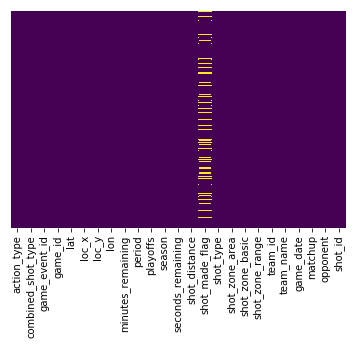

In [19]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [20]:
#drop rows with na values in the target feature and reset the index so we dont have anything missing
data = data[data['shot_made_flag'].notnull()].reset_index() 

In [21]:
data['game_date'] = pd.to_datetime(data['game_date'])
data['game_day'] = data['game_date'].apply(lambda x: x.weekday()) ## 0 is Monday, 1 is Tuesday .... 7 is Sunday

I am going to use "minutes_remaining", "seconds_remaining" and "period" to create some additional features to have an easier grasp of the time

In [22]:
data['period'].unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [23]:
# 12 minutes per period but it is a countdown so we subtract from 11
data['minutes_from_period_start'] = 11 - data['minutes_remaining']
data['seconds_from_period_start'] = 60*data['minutes_from_period_start'] + (60 - data['seconds_remaining']) 
# Simple Logic
data['minutes_from_game_start'] = (data['period'] <= 4).astype(int)*((data['period'] - 1 )*12 + data['minutes_from_period_start']) \
+ (data['period'] > 4).astype(int)*((data['period'] - 5)*6 + 4*12 + data['minutes_from_period_start'])
data['seconds_from_game_start'] = (data['period'] <= 4).astype(int)*((data['period'] - 1 )*12*60 + data['seconds_from_period_start']) \
+ (data['period'] > 4).astype(int)*((data['period'] - 5)*6*60 + 4*12*60 + data['minutes_from_period_start'])

In [24]:
#sample and check if the new features added are correct ( compare 'period' with 'minutes_from_*_start' )
data[['period','minutes_remaining','seconds_remaining','minutes_from_period_start','seconds_from_period_start','minutes_from_game_start','seconds_from_game_start']].head()

,period,minutes_remaining,seconds_remaining,minutes_from_period_start,seconds_from_period_start,minutes_from_game_start,seconds_from_game_start
0,1,10,22,1,98,1,98
1,1,7,45,4,255,4,255
2,1,6,52,5,308,5,308
3,2,6,19,5,341,17,1061
4,3,9,32,2,148,26,1588


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25697 entries, 0 to 25696
Data columns (total 31 columns):
index                        25697 non-null int64
action_type                  25697 non-null object
combined_shot_type           25697 non-null object
game_event_id                25697 non-null int64
game_id                      25697 non-null int64
lat                          25697 non-null float64
loc_x                        25697 non-null int64
loc_y                        25697 non-null int64
lon                          25697 non-null float64
minutes_remaining            25697 non-null int64
period                       25697 non-null int64
playoffs                     25697 non-null int64
season                       25697 non-null object
seconds_remaining            25697 non-null int64
shot_distance                25697 non-null int64
shot_made_flag               25697 non-null float64
shot_type                    25697 non-null object
shot_zone_area               25

plots

In [26]:
data['shot_made_flag'] = data['shot_made_flag'].astype(int)

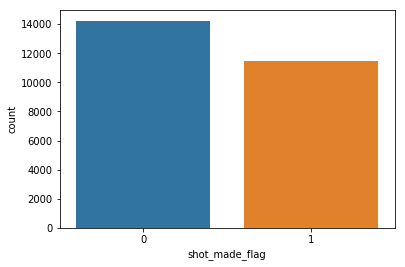

In [138]:
sns.countplot(data=data,x='shot_made_flag')

In [225]:
time_bins = np.arange(0,60*(4*12+3*5),20)+0.01 #20 means that every 20 seconds there is a bin

In [226]:
x = np.arange(0,1880,10)

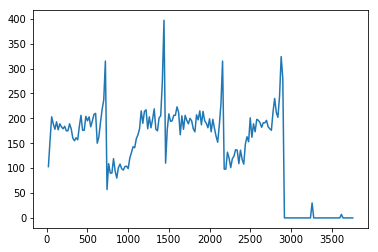

In [231]:
plt.plot(time_bins[1:],attemptsAsFunctionOfTime)

lets plot the shooting attemps as a function of time

In [264]:
time_bins = np.arange(0,60*(4*12+3*5),24)+0.01 #20 means that every 20 seconds there is a bin

In [265]:
attemptsAsFunctionOfTime, b = np.histogram(data['seconds_from_game_start'],bins=time_bins)

In [266]:
barWidth = 0.999*(time_bins[1]-time_bins[0])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

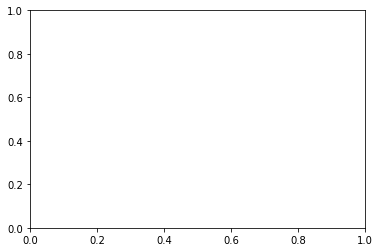

In [267]:
plt.bar(timeBins[:-1],attemptsAsFunctionOfTime,\
          align='edge', width=barWidth)